# Unsupervised Clustering 

### These notebook does 5 things:
1. Ingest the ckpt_file
2. For each sparse image, create many patches and embed them.
3. Perform unsupervised clustering of the *patch embeddings* and generate *patch annotations*. 
4. Combine the patch annotations into large images for visualization.
5. Evaluate the image_annotations at the discrete locations of the original data to generate *cell_or_gene annotations*.

### Common Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy

from tissue_purifier.data_utils.datamodule import SlideSeqTestisDM
from tissue_purifier.model_utils.dino import DinoModel

In [5]:
import neptune.new as neptune
NEPTUNE_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTkyYmJiYi0wN2E1LTRkY2YtOWU3Ny1kNjhjYmM3ZTVkNWEifQ=="
NEPTUNE_PROJECT = "cellarium/tissue-purifier"

#ckpt_file = 'ckpt_TIS_819.pt'  # do 723 after
ckpt_file = 'ckpt_TIS_723.pt'  # do 723 after

exp: neptune.run.Run = neptune.init(project=NEPTUNE_PROJECT,
                                    api_token=NEPTUNE_TOKEN,
                                    mode="async", #"offline", #"async",
                                    tags=["valiadation", ckpt_file],
                                   )

https://app.neptune.ai/cellarium/tissue-purifier/e/TIS-829
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


### Read from file and re-create the model and datamodule

In [6]:
# Get the model from checkpoint
dino = DinoModel.load_from_checkpoint(ckpt_file, strict=False)
config = dino._hparams
config["gpus"] = min(1, torch.cuda.device_count())
config["n_crops_for_tissue_test"] = 20 

# Get the datamodule from config stored in the model
dm = SlideSeqTestisDM(**config)
try:
    dm_cropper = dm.cropper_reference
except AttributeError:
    dm_cropper = dm.cropper_test
    
dm_transform = dm.trsfm_reference

# Extract the train_dataset made of full images
dm.prepare_data()
dm.setup()
train_loader = dm.train_dataloader()
train_dataset = train_loader.dataset

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:206: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['population_t', 'population_s']
  f"Found keys that are in the model state dict but not in the checkpoint: {keys.missing_keys}"


-----> running datamodule init
-----> running datamodule prepare_data
number of elements ---> 31659
mean and median spacing 15.622264926052864, 15.420071793081707
The dense shape of the image is -> torch.Size([9, 1178, 1178])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 31649     5]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 31629    15]
number of elements ---> 33059
mean and median spacing 15.358030584634598, 15.508166323067783
The dense shape of the image is -> torch.Size([9, 1180, 855])
Occupacy (zero, single, double, ...) of voxels in 3D sparse array -> [    0 33033    13]
Occupacy (zero, single, double, ...) of voxels  in 2D sparse array (summed over category) -> [    0 32973    43]
number of elements ---> 39206
mean and median spacing 15.535967840319682, 15.438280914030202
The dense shape of the image is -> torch.Size([9, 1179, 1180])
Occupacy (zero, single, double, ...) of voxels in 3D sparse

## Use the sp_img.analyze_with_tiling to generate the patch embeddings

In [7]:
from tissue_purifier.model_utils.patch_analyzer import PatchEncoder
from tissue_purifier.misc_utils.spatial_util import SpatialAutocorrelation
from tissue_purifier.misc_utils.misc import inspect_dict

In [8]:
train_loader = dm.train_dataloader()
train_dataset = train_loader.dataset
sp_images = train_dataset.imgs
metadatas = train_dataset.metadatas

In [9]:
f_names = [meta.f_name for meta in metadatas]

fname_patches = []
for f_name in f_names:
    fname_patches += [f_name]*500 

In [10]:
path_encoder = PatchEncoder(
    dino_model=dino,
    datamodule=dm,
    spatial_score_calculator=SpatialAutocorrelation(
        modality='moran',
        n_neighbours=6),
    )

for sp_img in sp_images:
    embeddings = sp_img.analyze_with_tiling(
        cropper=dm_cropper, 
        analyzer=path_encoder,
        n_patches_max=500,
        batch_size=64,
        overwrite=True)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
inspect_dict(sp_img.patch_properties_dict)

features_student_bbone <class 'torch.Tensor'> torch.Size([500, 128]) cpu
features_teacher_bbone <class 'torch.Tensor'> torch.Size([500, 128]) cpu
features_student_head <class 'torch.Tensor'> torch.Size([500, 128]) cpu
features_teacher_head <class 'torch.Tensor'> torch.Size([500, 128]) cpu
features_composition <class 'torch.Tensor'> torch.Size([500, 9]) cpu
patch_xywh <class 'torch.Tensor'> torch.Size([500, 4]) cpu
spatial_score <class 'torch.Tensor'> torch.Size([500, 9]) cpu


# Concatenate the embeddings from all the images

In [12]:
from tissue_purifier.misc_utils.misc import concatenate_list_of_dict

In [13]:
list_of_dict = [sp_img.patch_properties_dict for sp_img in sp_images]
embeddings_dict = concatenate_list_of_dict(list_of_dict)
inspect_dict(embeddings_dict)

features_student_bbone <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_teacher_bbone <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_student_head <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_teacher_head <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_composition <class 'torch.Tensor'> torch.Size([3000, 9]) cpu
patch_xywh <class 'torch.Tensor'> torch.Size([3000, 4]) cpu
spatial_score <class 'torch.Tensor'> torch.Size([3000, 9]) cpu


In [14]:
embeddings_dict["regress_moran"] = embeddings_dict["spatial_score"].max(dim=-1)[0]
embeddings_dict["classify_tissue_label"] = fname_patches
embeddings_dict["classify_condition"] = [fname.startswith("wt") for fname in fname_patches]

inspect_dict(embeddings_dict)

features_student_bbone <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_teacher_bbone <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_student_head <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_teacher_head <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_composition <class 'torch.Tensor'> torch.Size([3000, 9]) cpu
patch_xywh <class 'torch.Tensor'> torch.Size([3000, 4]) cpu
spatial_score <class 'torch.Tensor'> torch.Size([3000, 9]) cpu
regress_moran <class 'torch.Tensor'> torch.Size([3000]) cpu
classify_tissue_label <class 'list'> 3000
classify_condition <class 'list'> 3000


# Compute PCA, UMAP, Leiden for all features

In [15]:
from tissue_purifier.misc_utils.misc import SmartPca, SmartUmap, SmartLeiden

In [16]:
#feature_keys = []
#for key in embeddings_dict.keys():
#    if key.startswith("feature"):
#        feature_keys.append(key)

feature_keys = ['features_teacher_bbone', 'features_composition']

print(feature_keys)

['features_teacher_bbone', 'features_composition']


In [17]:
for key in feature_keys:
    print("working on -->", key)
    if key.endswith("composition"):
        smart_pca = SmartPca(preprocess_strategy='z_score')
        smart_umap = SmartUmap(n_neighbors=25, preprocess_strategy='raw', n_components=2, min_dist=0.5)
        input_features = embeddings_dict[key]
        embeddings_pca = smart_pca.fit_transform(input_features, n_components=0.9)
        embeddings_umap = smart_umap.fit_transform(input_features)
        umap_graph = smart_umap.get_graph()
    else:
        smart_pca = SmartPca(preprocess_strategy='z_score')
        smart_umap = SmartUmap(n_neighbors=25, preprocess_strategy='raw', n_components=2, min_dist=0.5)
        input_features = embeddings_dict[key]
        embeddings_pca = smart_pca.fit_transform(input_features, n_components=0.9)
        embeddings_umap = smart_umap.fit_transform(embeddings_pca)
        umap_graph = smart_umap.get_graph()
    
    embeddings_dict["pca_"+key] = torch.from_numpy(embeddings_pca)
    embeddings_dict["umap_"+key] = torch.from_numpy(embeddings_umap)
    
    smart_leiden = SmartLeiden(graph=umap_graph)
    for resolution in [0.01, 0.1, 0.3, 0.5, 1.0]:
        cluster_labels = smart_leiden.cluster(resolution=resolution)
        embeddings_dict["leiden_res_"+str(resolution)+"_"+key] = torch.nn.functional.one_hot(torch.from_numpy(cluster_labels).long())  # need to make it one-hot so that I can average            

working on --> features_teacher_bbone
working on --> features_composition


In [18]:
inspect_dict(embeddings_dict)

features_student_bbone <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_teacher_bbone <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_student_head <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_teacher_head <class 'torch.Tensor'> torch.Size([3000, 128]) cpu
features_composition <class 'torch.Tensor'> torch.Size([3000, 9]) cpu
patch_xywh <class 'torch.Tensor'> torch.Size([3000, 4]) cpu
spatial_score <class 'torch.Tensor'> torch.Size([3000, 9]) cpu
regress_moran <class 'torch.Tensor'> torch.Size([3000]) cpu
classify_tissue_label <class 'list'> 3000
classify_condition <class 'list'> 3000
pca_features_teacher_bbone <class 'torch.Tensor'> torch.Size([3000, 24]) cpu
umap_features_teacher_bbone <class 'torch.Tensor'> torch.Size([3000, 2]) cpu
leiden_res_0.01_features_teacher_bbone <class 'torch.Tensor'> torch.Size([3000, 1]) cpu
leiden_res_0.1_features_teacher_bbone <class 'torch.Tensor'> torch.Size([3000, 1]) cpu
leiden_res_0.3_features_teacher_bbone <clas

# Plot a lot of maps

In [19]:
from tissue_purifier.plot_utils.plot_embeddings import plot_all_maps

maps = plot_all_maps(embeddings_dict, legend=False)

for tmp in maps:
    exp["maps"].log(neptune.types.File.as_image(tmp))

# Evaluate the embeddings
can the patch embeddings predict: 
- tissue_label, 
- tissue_condition, 
- moran_score

Compare features_composition vs dino_features

In [23]:
from tissue_purifier.model_utils.classify_regress import classify_and_regress
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier

mlp_kargs = {
    "hidden_layer_sizes" : [],
    "solver": 'adam',
    "alpha" : 0.0001,
    "batch_size" : 'auto',
    "learning_rate" : 'constant',
    "learning_rate_init" : 0.0003,
    "max_iter" : 50000,
    "shuffle" : True,
    "random_state" : 1,
    "tol" : 1E-6,
    "verbose" : False,
    "n_iter_no_change" : 10,
    "early_stopping" :False,
}

kn_kargs = {
    "n_neighbors": 5,
}

feature_keys, regress_keys, classify_keys = [], [], []
for key in embeddings_dict.keys():
    #if key.startswith("pca") or key.startswith("umap") or key in ['features_teacher_bbone', 'features_composition']:
    if key in ['features_teacher_bbone', 'features_composition']:
        feature_keys.append(key)
    elif key.startswith("regress"):
        regress_keys.append(key)
    elif key.startswith("classify"):
        classify_keys.append(key)

#result_dict_mlp = classify_and_regress(
#    input_dict=embeddings_dict, 
#    feature_keys=feature_keys, 
#    regress_keys=regress_keys,
#    classify_keys=classify_keys,
#    regressor=MLPRegressor(**mlp_kargs),
#    classifier=MLPClassifier(**mlp_kargs),
#    add_prediction=False, 
#    verbose=True)

result_dict_kn = classify_and_regress(
    input_dict=embeddings_dict, 
    feature_keys=feature_keys, 
    regress_keys=regress_keys,
    classify_keys=classify_keys,
    regressor=KNeighborsRegressor(**kn_kargs),
    classifier=KNeighborsClassifier(**kn_kargs),
    add_prediction=False, 
    verbose=True)

features_teacher_bbone
features_composition


In [24]:
result_dict_kn

{'features_teacher_bbone': {'classify_tissue_label_accuracy_test': 0.9383333333333334,
  'classify_tissue_label_accuracy_train': 0.9708333333333333,
  'classify_condition_accuracy_test': 0.9583333333333334,
  'classify_condition_accuracy_train': 0.9879166666666667,
  'regress_moran_r2_test': 0.8763070972006142,
  'regress_moran_r2_train': 0.9152835370328142},
 'features_composition': {'classify_tissue_label_accuracy_test': 0.7866666666666666,
  'classify_tissue_label_accuracy_train': 0.8645833333333334,
  'classify_condition_accuracy_test': 0.875,
  'classify_condition_accuracy_train': 0.915,
  'regress_moran_r2_test': 0.6133730545831113,
  'regress_moran_r2_train': 0.710666576001998}}

In [28]:
exp["regress_and_classify_kn"] = result_dict_kn

In [29]:
#for kf, kf_dict in result_dict_kn.items():
#    for k, metric in kf_dict.items():
#        exp["regress"].log
#        #exp["regress_and_classify/kn/"+kf+"/"+k].log(metric)

In [25]:
#result_dict_mlp

In [ ]:
#for kf, kf_dict in result_dict_mlp.items():
#    for k, metric in kf_dict.items():
#        exp["regress_and_classify/mlp/"+kf+"/"+k].log(metric)
#    

In [64]:
from tissue_purifier.plot_utils.plot_misc import plot_bars

result_dict = result_dict_kn

keys_metric = set()
for kf, d_tmp in result_dict.items(): 
    for key in d_tmp.keys():
        if key.endswith("accuracy_test") or key.endswith("r2_test"):
            keys_metric.add(key)
            
print(keys_metric)

def compare_features_according_to_metric(dict_result, key_metric):
    x_labels = []
    metric_values = []
    for kf, kf_dict in dict_result.items():
        if key_metric in kf_dict.keys():
            x_labels.append(kf)
            metric_values.append(kf_dict[key_metric])
    return x_labels, metric_values

figs = []
for key_metric in keys_metric:
    x_labels, y_values = compare_features_according_to_metric(result_dict, key_metric)
    fig = plot_bars(y_values, x_labels=x_labels, title=key_metric)
    figs.append(fig)
    exp["feature_comparison"].log(neptune.types.File.as_image(fig))

{'regress_moran_r2_test', 'classify_tissue_label_accuracy_test', 'classify_condition_accuracy_test'}


In [65]:
result_dict_kn

{'features_teacher_bbone': {'classify_tissue_label_accuracy_test': 0.9383333333333334,
  'classify_tissue_label_accuracy_train': 0.9708333333333333,
  'classify_condition_accuracy_test': 0.9583333333333334,
  'classify_condition_accuracy_train': 0.9879166666666667,
  'regress_moran_r2_test': 0.8763070972006142,
  'regress_moran_r2_train': 0.9152835370328142},
 'features_composition': {'classify_tissue_label_accuracy_test': 0.7866666666666666,
  'classify_tissue_label_accuracy_train': 0.8645833333333334,
  'classify_condition_accuracy_test': 0.875,
  'classify_condition_accuracy_train': 0.915,
  'regress_moran_r2_test': 0.6133730545831113,
  'regress_moran_r2_train': 0.710666576001998}}

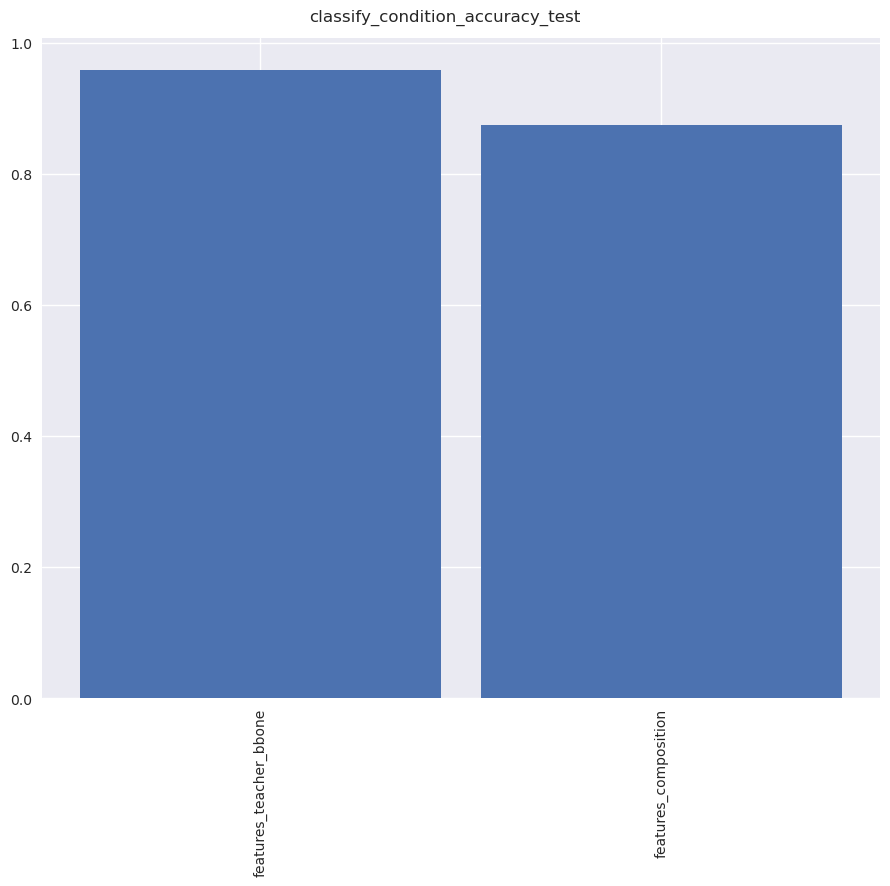

In [34]:
figs[2]

# Transfer annotation to the sp_img._image_properties dict

In [35]:
from tissue_purifier.misc_utils.misc import transfer_annotations_between_dict
     
annotation_keys = []
for key in embeddings_dict.keys():
    if key.startswith("pca") or key.startswith("umap") or key.startswith("leiden") or key.startswith("spatial_score"):
        annotation_keys.append(key)
print(annotation_keys)
    
for sp_img in sp_images:    
    transfer_annotations_between_dict(
        source_dict=embeddings_dict,
        dest_dict=sp_img.patch_properties_dict,
        annotation_keys=annotation_keys,
        anchor_key="features_student_bbone",
    )

inspect_dict(sp_images[0].patch_properties_dict)

['spatial_score', 'pca_features_teacher_bbone', 'umap_features_teacher_bbone', 'leiden_res_0.01_features_teacher_bbone', 'leiden_res_0.1_features_teacher_bbone', 'leiden_res_0.3_features_teacher_bbone', 'leiden_res_0.5_features_teacher_bbone', 'leiden_res_1.0_features_teacher_bbone', 'pca_features_composition', 'umap_features_composition', 'leiden_res_0.01_features_composition', 'leiden_res_0.1_features_composition', 'leiden_res_0.3_features_composition', 'leiden_res_0.5_features_composition', 'leiden_res_1.0_features_composition']
features_student_bbone <class 'torch.Tensor'> torch.Size([500, 128]) cpu
features_teacher_bbone <class 'torch.Tensor'> torch.Size([500, 128]) cpu
features_student_head <class 'torch.Tensor'> torch.Size([500, 128]) cpu
features_teacher_head <class 'torch.Tensor'> torch.Size([500, 128]) cpu
features_composition <class 'torch.Tensor'> torch.Size([500, 9]) cpu
patch_xywh <class 'torch.Tensor'> torch.Size([500, 4]) cpu
spatial_score <class 'torch.Tensor'> torch.S

# Make an image out of the annotations

In [36]:
from tissue_purifier.plot_utils.plot_misc import plot_counters

In [37]:
annotation_keys

['spatial_score',
 'pca_features_teacher_bbone',
 'umap_features_teacher_bbone',
 'leiden_res_0.01_features_teacher_bbone',
 'leiden_res_0.1_features_teacher_bbone',
 'leiden_res_0.3_features_teacher_bbone',
 'leiden_res_0.5_features_teacher_bbone',
 'leiden_res_1.0_features_teacher_bbone',
 'pca_features_composition',
 'umap_features_composition',
 'leiden_res_0.01_features_composition',
 'leiden_res_0.1_features_composition',
 'leiden_res_0.3_features_composition',
 'leiden_res_0.5_features_composition',
 'leiden_res_1.0_features_composition']

In [38]:
for sp_img in sp_images:

    image_dict = sp_img.path_property_to_image_property(
        keys=annotation_keys,
        patch_xywh=sp_img.patch_properties_dict["patch_xywh"],
        overwrite=True)

In [39]:
inspect_dict(image_dict)
image_keys = image_dict.keys()

print(image_keys)

spatial_score <class 'torch.Tensor'> torch.Size([9, 1164, 1165]) cpu
pca_features_teacher_bbone <class 'torch.Tensor'> torch.Size([24, 1164, 1165]) cpu
umap_features_teacher_bbone <class 'torch.Tensor'> torch.Size([2, 1164, 1165]) cpu
leiden_res_0.01_features_teacher_bbone <class 'torch.Tensor'> torch.Size([1, 1164, 1165]) cpu
leiden_res_0.1_features_teacher_bbone <class 'torch.Tensor'> torch.Size([1, 1164, 1165]) cpu
leiden_res_0.3_features_teacher_bbone <class 'torch.Tensor'> torch.Size([5, 1164, 1165]) cpu
leiden_res_0.5_features_teacher_bbone <class 'torch.Tensor'> torch.Size([8, 1164, 1165]) cpu
leiden_res_1.0_features_teacher_bbone <class 'torch.Tensor'> torch.Size([20, 1164, 1165]) cpu
pca_features_composition <class 'torch.Tensor'> torch.Size([6, 1164, 1165]) cpu
umap_features_composition <class 'torch.Tensor'> torch.Size([2, 1164, 1165]) cpu
leiden_res_0.01_features_composition <class 'torch.Tensor'> torch.Size([1, 1164, 1165]) cpu
leiden_res_0.1_features_composition <class 't

# Visualize the image_properties

In [40]:
from tissue_purifier.plot_utils.plot_images import show_raw_all_channels, show_raw_one_channel

### Plot the moran score

In [41]:
for cell_type, code in sp_images[0]._categories_to_codes.items():
    fig = show_raw_one_channel([sp_img.image_properties_dict["spatial_score"][code] for sp_img in sp_images], n_col=3, 
                               titles=f_names, sup_title="Moran of {0}".format(cell_type), cmap="magma")
    exp["masks/moran"].log(neptune.types.File.as_image(fig))

### Plot the Lieden cluster

In [43]:
for key in image_keys:
    if key.startswith("leiden"):
        print(key)
        fig = show_raw_all_channels([sp_img.image_properties_dict[key] for sp_img in sp_images], n_col=3, titles=f_names, sup_title=key, cmap=plt.cm.tab10, show_colorbar=False)
        exp["masks/leiden/all_chs"].log(neptune.types.File.as_image(fig))
        
        #for sp_img, f_name in zip(sp_images, f_names):
        #    fig = show_raw_one_channel(sp_img.image_properties_dict[key], sup_title="{0} by {1}".format(f_name,key))
        #    exp["masks/leiden/"+key].log(neptune.types.File.as_image(fig))

leiden_res_0.01_features_teacher_bbone
leiden_res_0.1_features_teacher_bbone
leiden_res_0.3_features_teacher_bbone
leiden_res_0.5_features_teacher_bbone
leiden_res_1.0_features_teacher_bbone
leiden_res_0.01_features_composition
leiden_res_0.1_features_composition
leiden_res_0.3_features_composition
leiden_res_0.5_features_composition
leiden_res_1.0_features_composition


### Plot the PCA components

In [44]:
for key in image_keys:
    if key.startswith("pca"):
        print(key)
        fig = show_raw_one_channel([sp_img.image_properties_dict[key][0] for sp_img in sp_images], n_col=3, titles=f_names, sup_title="PCA1 by "+key, cmap="seismic")
        exp["masks/pca"].log(neptune.types.File.as_image(fig))
        fig = show_raw_one_channel([sp_img.image_properties_dict[key][1] for sp_img in sp_images], n_col=3, titles=f_names, sup_title="PCA2 by "+key, cmap="seismic")
        exp["masks/pca"].log(neptune.types.File.as_image(fig))

pca_features_teacher_bbone
pca_features_composition


### Plot the UMAP components

In [45]:
for key in image_keys:
    if key.startswith("umap"):
        print(key)
        fig = show_raw_one_channel([sp_img.image_properties_dict[key][0] for sp_img in sp_images], n_col=3, titles=f_names, sup_title="UMAP1 by "+key, cmap="seismic")
        exp["masks/umap"].log(neptune.types.File.as_image(fig))
        fig = show_raw_one_channel([sp_img.image_properties_dict[key][1] for sp_img in sp_images], n_col=3, titles=f_names, sup_title="UMAP2 by "+key, cmap="seismic")
        exp["masks/umap"].log(neptune.types.File.as_image(fig))

umap_features_teacher_bbone
umap_features_composition


# Usage statistics

In [46]:
from tissue_purifier.plot_utils.plot_misc import plot_counters
from tissue_purifier.misc_utils.misc import channel_counter_in_window

In [47]:
for key in image_keys:
    if key.startswith("leiden"):
        print(key)
        leiden_counters = [channel_counter_in_window(sp_img.image_properties_dict[key]) for sp_img in sp_images]
        fig = plot_counters(leiden_counters, dataset_labels=f_names, title="normalized utilization of clusters by {0}".format(key))
        exp["usage"].log(neptune.types.File.as_image(fig))

leiden_res_0.01_features_teacher_bbone
leiden_res_0.1_features_teacher_bbone
leiden_res_0.3_features_teacher_bbone
leiden_res_0.5_features_teacher_bbone
leiden_res_1.0_features_teacher_bbone
leiden_res_0.01_features_composition
leiden_res_0.1_features_composition
leiden_res_0.3_features_composition
leiden_res_0.5_features_composition
leiden_res_1.0_features_composition


In [48]:
cell_types = list(sp_images[0]._categories_to_codes.keys())

cell_counters = [channel_counter_in_window(sp_img) for sp_img in sp_images]
fig = plot_counters(cell_counters, dataset_labels=f_names, title="normalized utilization of cells", x_labels=cell_types)
exp["usage"].log(neptune.types.File.as_image(fig))

# Interpret the clusters

Give meaning to the leiden_clusters compute: cell composition, gene expression, moran score

In [49]:
#torch.save(embeddings_dict, "embedding_dict_723.pt")
#torch.save(sp_images, "sp_images_with_saved_info_723.pt")

In [81]:
sp=sp_images[0]

In [83]:
print(sp.image_properties_dict["leiden_res_0.3_features_teacher_bbone"].shape)


torch.Size([5, 1178, 1178])


In [78]:
binarized = torch.argmax(sp.image_properties_dict["leiden_res_0.3_features_teacher_bbone"], dim=0)

In [79]:
binarized.max()

tensor(4)

In [52]:
sp = sp_images[0]

In [56]:
sp.image_properties_dict.keys()

dict_keys(['spatial_score', 'pca_features_teacher_bbone', 'umap_features_teacher_bbone', 'leiden_res_0.01_features_teacher_bbone', 'leiden_res_0.1_features_teacher_bbone', 'leiden_res_0.3_features_teacher_bbone', 'leiden_res_0.5_features_teacher_bbone', 'leiden_res_1.0_features_teacher_bbone', 'pca_features_composition', 'umap_features_composition', 'leiden_res_0.01_features_composition', 'leiden_res_0.1_features_composition', 'leiden_res_0.3_features_composition', 'leiden_res_0.5_features_composition', 'leiden_res_1.0_features_composition'])

In [57]:
image_keys = list(sp.patch_properties_dict.keys())

In [63]:
for key in image_keys:
    if key.startswith("leiden"):
        #print(key)
        #fig = show_raw_all_channels([sp_img.image_properties_dict[key] for sp_img in sp_images], n_col=3, titles=f_names, sup_title=key, cmap=plt.cm.tab10, show_colorbar=False)
        #exp["masks/leiden/all_chs"].log(neptune.types.File.as_image(fig))
        
        for sp_img, f_name in zip(sp_images, f_names):
            if sp_img.image_properties_dict[key].shape[0] > 1:
                fig = show_raw_one_channel(sp_img.image_properties_dict[key], sup_title="{0} by {1}".format(f_name,key))
                exp["masks/one_ch_leiden/"+key].log(neptune.types.File.as_image(fig))

In [54]:
vars(sp)

{'_x_name': 'x',
 '_y_name': 'y',
 '_cat_name': 'cell_type',
 '_categories_to_codes': {'ES': 0,
  'Endothelial': 1,
  'Leydig': 2,
  'Macrophage': 3,
  'Myoid': 4,
  'RS': 5,
  'SPC': 6,
  'SPG': 7,
  'Sertoli': 8},
 'patch_properties_dict': {'features_student_bbone': tensor([[ 0.1689, -0.6703,  1.6377,  ..., -0.3563, -0.2315, -0.8786],
          [ 0.7061, -1.1092,  0.7791,  ...,  0.7552,  0.2920, -0.3942],
          [-0.6388, -1.4623, -1.1308,  ..., -0.4929,  0.5656,  0.3617],
          ...,
          [-0.6113, -1.4823,  0.1804,  ..., -0.3187,  0.1803, -0.7937],
          [-0.3189, -2.4066, -0.7261,  ..., -0.5450,  0.5832, -0.4288],
          [ 0.1345, -0.2447,  0.5570,  ..., -0.1608,  0.0428,  0.4448]]),
  'features_teacher_bbone': tensor([[ 0.0125, -0.8151,  1.7545,  ..., -0.3607, -0.5190, -0.6953],
          [ 0.6667, -0.9397,  0.6342,  ...,  0.8003,  0.4453, -0.3389],
          [-0.4701, -1.5752, -1.0613,  ..., -0.3157,  0.4277,  0.0537],
          ...,
          [-0.3296, -1.3471

In [51]:
sp_images

# Transfer onto spots

# so that we can do differential gene expression

In [ ]:
#print("before")
#sp_img._original_data

#sp_img.image_property_to_spot_property(
#    keys=image_keys)

In [ ]:
exp.stop()